In [1]:
%load_ext autoreload
%autoreload 2

# Import

In [2]:
import numpy as np
import hypertools as hyp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import itertools
from collections import defaultdict

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering, KMeans
from tommas.viz.embedding_plot import extract_embeddings_and_labels
from sklearn.metrics import silhouette_samples, silhouette_score

from transformers import GPT2Model, GPT2Config, GPT2LMHeadModel, GPT2Tokenizer, GPT2ForSequenceClassification, PreTrainedTokenizerFast
from tokenizers import Tokenizer, models, normalizers, pre_tokenizers, processors
import ecco
from ecco import LM, pack_tokenizer_config
import ecco.analysis as analysis

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import seed_everything

from tommas.agent_modellers.iterative_action_tommas_transformer import IterativeActionTOMMASTransformer
from tommas.agents.create_iterative_action_agents import get_random_iterative_action_agent, RandomStrategySampler
from tommas.data.iterative_action_dataset import IterativeActionTrajectory, play_episode
from tommas.data.gridworld_transforms import IterativeActionFullPastCurrentSplit
from tommas.data.datamodule_factory import make_datamodule
from experiments.experiment_base import load_modeller

from tommas.viz.embedding_responsibility import plot_embedding_responsibility
from tommas.viz.embedding_plot import plot_embeddings, hyp_plot

from tommas.analysis.representation_metrics_gridworld import lstm_ttx_boxplot_comparison, \
    get_representation_similarity_score, lstm_ttx_agent_param_boxplot_comparison, calculate_df_corr, \
    load_representation_data, calculate_and_combine_model_corr, calculate_model_param_corr, \
    calculate_model_specific_corr

# Load Data

In [3]:
agent_specific_df = load_representation_data("agent_specific")
model_specific_df = load_representation_data("model_specific")
architecture_df = load_representation_data("architecture")
model_param_df = load_representation_data("model_param")

In [80]:
ttx_df = agent_specific_df[agent_specific_df["lstm_char"] == False]

In [81]:
p0_df = ttx_df[ttx_df["n_past"] == 0]
p5_df = ttx_df[ttx_df["n_past"] == 5]

In [84]:
p0_df.groupby(["model_name"])[["loss", "acc"]].agg(["describe"])

KeyError: "Columns not found: 'loss', 'acc'"

In [85]:
p0_df.columns

Index(['model_name', 'model_family', 'model_seed', 'lstm_char', 'lstm_mental',
       'char_embedding_size', 'char_n_layer', 'char_n_head',
       'mental_embedding_size', 'mental_n_layer', 'mental_n_head',
       'agent_label', 'agent_type', 'goal_ranker_type', 'goal_rewards',
       'n_past', 'char_embedding', 'action_loss', 'action_acc', 'goal_loss',
       'goal_acc', 'goal_ranker_type_score', 'goal_ranker_type_dim',
       'goal_rewards_score', 'goal_rewards_dim', 'cluster_silhouette_score',
       'modified_cluster_silhouette_score'],
      dtype='object')

# Embedding Plot

In [4]:
def plot_df_embeddings(df, model_name, label_by="agent_type", remove_missing_labels=False, n_past=5, current_traj_len=19,
                       plot_char_embedding=True, agent_type=None, short_title=False, **kwargs):

#     filtered_df = df
    filtered_df = df[(df["n_past"] == n_past) & (df["model_name"] == model_name)]
    if agent_type is not None:
        filtered_df = filtered_df[filtered_df["agent_type"] == agent_type]

#     if agent_type is not None:
#         if type(agent_type) == str:
#             agent_type = [agent_type]
#         acceptable_agent_ids = []
#         for agent_id, agent_data in metadata.items():
#             if agent_data["agent_type"] in agent_type:
#                 acceptable_agent_ids.append(agent_id)
#         filtered_df = df[df["agent_id"].isin(acceptable_agent_ids)]

#     embeddings, labels = extract_embeddings_and_labels(filtered_df, metadata, label_by, remove_missing_labels, n_past,
#                                                        current_traj_len, plot_char_embedding)
    if isinstance(label_by, str):
        label_by = [label_by]
    embeddings = []
    labels = []
    for label_id, group_series in filtered_df[[*label_by, "char_embedding"]].groupby(label_by):
        print(label_id)
        a = np.concatenate(group_series.char_embedding.tolist())
        embeddings.append(a)
        labels += [label_id for _ in range(len(a))]
    embeddings = np.concatenate(embeddings)
    

    title = f"Embeddings grouped by: {label_by}"

#     if len(embeddings.shape) == 3:
#         embedding_idx = 1
#         embedding_name = "Mental"
#         if plot_char_embedding:
#             embedding_idx = 0
#             embedding_name = "Character"
#         embeddings = embeddings[:, embedding_idx]
#         embeddings = np.stack(embeddings, axis=0).astype(float)
#         title = f"{embedding_name} embeddings grouped by: {label_by}"

#     if short_title:
#         title = f"{label_by}"

    hyp_plot(embeddings, labels, title=title, **kwargs)

closest
discount
highest


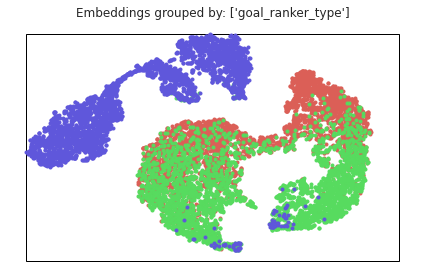

In [5]:
plot_df_embeddings(agent_specific_df, 'ttx[64,8,8]_ttx[64,4,8]_seed1', label_by="goal_ranker_type", ndims=2, reduce="TSNE")

closest
discount
highest


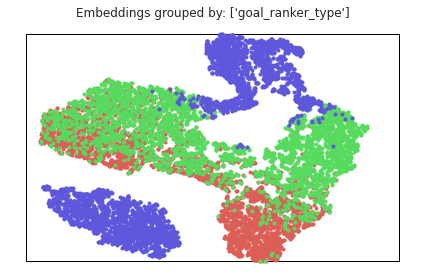

In [6]:
plot_df_embeddings(agent_specific_df, 'ttx[128,8,8]_ttx[64,4,8]_seed4', label_by="goal_ranker_type", ndims=2, reduce="TSNE")

closest
discount
highest


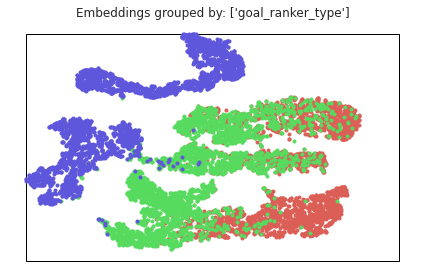

In [7]:
plot_df_embeddings(agent_specific_df, 'lstm[64,2]_lstm[64,2]_seed1', label_by="goal_ranker_type", ndims=2, reduce="TSNE")

closest
discount
highest


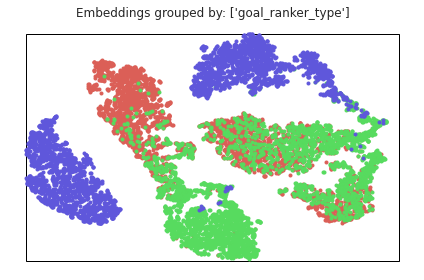

In [8]:
plot_df_embeddings(agent_specific_df, 'lstm[128,2]_lstm[64,2]_seed1', label_by="goal_ranker_type", ndims=2, reduce="TSNE")

collaborative
independent


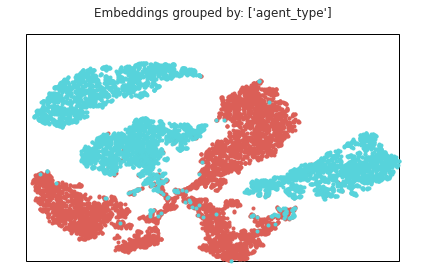

In [9]:
plot_df_embeddings(agent_specific_df, 'lstm[128,2]_lstm[64,2]_seed1', label_by="agent_type", ndims=2, reduce="TSNE")

collaborative
independent


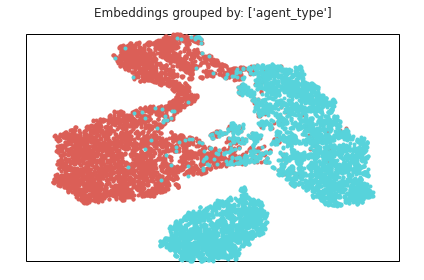

In [10]:
plot_df_embeddings(agent_specific_df, 'ttx[128,8,8]_ttx[64,4,8]_seed4', label_by="agent_type", ndims=2, reduce="TSNE")

('collaborative', 'closest')
('collaborative', 'discount')
('collaborative', 'highest')
('independent', 'closest')
('independent', 'discount')
('independent', 'highest')


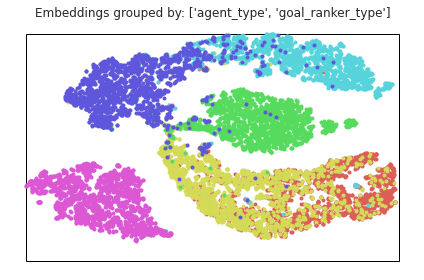

In [11]:
plot_df_embeddings(agent_specific_df, 'lstm[128,2]_lstm[64,2]_seed2', label_by=["agent_type", "goal_ranker_type"],
                   agent_type=None, ndims=2, reduce="TSNE")

('collaborative', 'closest')
('collaborative', 'discount')
('collaborative', 'highest')
('independent', 'closest')
('independent', 'discount')
('independent', 'highest')


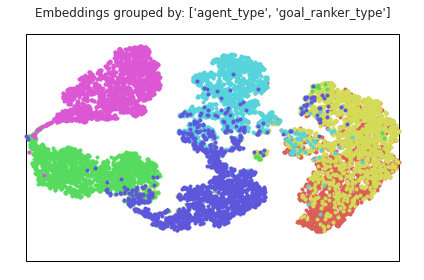

In [23]:
plot_df_embeddings(agent_specific_df, 'ttx[128,8,8]_ttx[64,4,8]_seed2', label_by=["agent_type", "goal_ranker_type"],
                   agent_type=None, ndims=2, reduce="TSNE")

# create_representation_df

## debug sample

In [5]:
def load_sample_models():
    trained_on = "Grid"

    params = [
              ("[64,2]", "[64,2]", list(range(1, 3))),
              ("[128,2]", "[64,2]", list(range(1, 3))),
#               ("[80,4,4]", "[64,4,4]", list(range(1, 3))), 
#               ("[128,4,4]", "[64,4,4]", list(range(1, 3))), 
             ]
        
    model_dict = dict()
    for char_params, mental_params, seeds in params:
        if char_params.count(',') == 2:
            char_net = "ttx"
        else:
            char_net = "lstm"
        if mental_params.count(',') == 2:
            mental_net = "ttx"
        else:
            mental_net = "lstm"
        if seeds != None:
#             multi_init_model_dict = dict()
            for seed in seeds:
                modeller_dirpath = f"data/models/gridworld/GridTNet[{trained_on}]_{char_net}{char_params}_{mental_net}{mental_params}_seed{seed}.ckpt"
                model_dict[f"{char_net}{char_params}_{mental_net}{mental_params}_seed{seed}"] = load_modeller(modeller_dirpath).to("cuda")
#                 model_dict[f"{char_net}{char_params}_{mental_net}{mental_params}_seed{seed}"] = multi_init_model_dict
        else:
            modeller_dirpath = f"data/models/gridworld/GridTNet[{trained_on}]_{char_net}{char_params}_{mental_net}{mental_params}.ckpt"
            model_dict[f"{char_net}{char_params}_{mental_net}{mental_params}"] = load_modeller(modeller_dirpath).to("cuda")
        
    return model_dict

In [6]:
model_dict = load_sample_models()

In [9]:
from tommas.analysis.representation_metrics_gridworld import get_agent_specific_data, extract_model_specific_data, extract_model_param_data, append_silhouette_scores_to_df, \
    aggregate_model_specific_data, append_final_embedding_similarity, append_pca_dims_to_df, append_model_specific_param_scores, \
    aggregate_model_param_data, append_representation_similarity_over_diff_init, extract_architecture_data, \
    generate_random_traj, _get_model_prediction_data, get_param_silhouette_and_dim, create_models_output_df

In [59]:
output_df = create_models_output_df(model_dict, num_agents_per_cluster=10)

Global seed set to 42
100%|██████████| 36/36 [00:46<00:00,  1.29s/it]


In [46]:
def compare_n_past(output_df):
    ttx_df = output_df[output_df["lstm_char"] == True]
    p0_df = ttx_df[ttx_df["n_past"] == 0]
    p2_df = ttx_df[ttx_df["n_past"] == 2]
#     p1_df = ttx_df[ttx_df["n_past"] == 1]
    print(p0_df.groupby(["model_name"])[["action_loss", "goal_loss"]].agg(["describe"])[[("action_loss", "describe", "mean"), ("goal_loss", "describe", "mean")]])
    print(p2_df.groupby(["model_name"])[["action_loss", "goal_loss"]].agg(["describe"])[[("action_loss", "describe", "mean"), ("goal_loss", "describe", "mean")]])

In [49]:
# untouched
compare_n_past(output_df)

                             action_loss goal_loss
                                describe  describe
                                    mean      mean
model_name                                        
lstm[128,2]_lstm[64,2]_seed1    0.483906  0.588371
lstm[128,2]_lstm[64,2]_seed2    0.471619  0.646301
lstm[64,2]_lstm[64,2]_seed1     0.489945  0.607198
lstm[64,2]_lstm[64,2]_seed2     0.491758  0.622107
                             action_loss goal_loss
                                describe  describe
                                    mean      mean
model_name                                        
lstm[128,2]_lstm[64,2]_seed1    0.468069  0.573848
lstm[128,2]_lstm[64,2]_seed2    0.458789  0.632044
lstm[64,2]_lstm[64,2]_seed1     0.474763  0.593261
lstm[64,2]_lstm[64,2]_seed2     0.476019  0.607159


In [60]:
# random gen char embedding
compare_n_past(output_df)

                             action_loss goal_loss
                                describe  describe
                                    mean      mean
model_name                                        
lstm[128,2]_lstm[64,2]_seed1    0.727485  0.690680
lstm[128,2]_lstm[64,2]_seed2    0.780655  0.930993
lstm[64,2]_lstm[64,2]_seed1     0.635753  0.673404
lstm[64,2]_lstm[64,2]_seed2     0.621822  0.760036
                             action_loss goal_loss
                                describe  describe
                                    mean      mean
model_name                                        
lstm[128,2]_lstm[64,2]_seed1    0.718409  0.687536
lstm[128,2]_lstm[64,2]_seed2    0.774782  0.934807
lstm[64,2]_lstm[64,2]_seed1     0.639643  0.672455
lstm[64,2]_lstm[64,2]_seed2     0.627184  0.749758


In [54]:
# randomly swap batches
compare_n_past(output_df)

                             action_loss goal_loss
                                describe  describe
                                    mean      mean
model_name                                        
lstm[128,2]_lstm[64,2]_seed1    0.483906  0.588371
lstm[128,2]_lstm[64,2]_seed2    0.471619  0.646301
lstm[64,2]_lstm[64,2]_seed1     0.489945  0.607198
lstm[64,2]_lstm[64,2]_seed2     0.491758  0.622107
                             action_loss goal_loss
                                describe  describe
                                    mean      mean
model_name                                        
lstm[128,2]_lstm[64,2]_seed1    0.467447  0.574729
lstm[128,2]_lstm[64,2]_seed2    0.458652  0.633547
lstm[64,2]_lstm[64,2]_seed1     0.474050  0.595086
lstm[64,2]_lstm[64,2]_seed2     0.475982  0.609186


In [56]:
# randomly swap embed values
compare_n_past(output_df)

                             action_loss goal_loss
                                describe  describe
                                    mean      mean
model_name                                        
lstm[128,2]_lstm[64,2]_seed1    0.470239  0.576598
lstm[128,2]_lstm[64,2]_seed2    0.462190  0.635701
lstm[64,2]_lstm[64,2]_seed1     0.476206  0.596044
lstm[64,2]_lstm[64,2]_seed2     0.478348  0.609105
                             action_loss goal_loss
                                describe  describe
                                    mean      mean
model_name                                        
lstm[128,2]_lstm[64,2]_seed1    0.470318  0.576078
lstm[128,2]_lstm[64,2]_seed2    0.460785  0.635995
lstm[64,2]_lstm[64,2]_seed1     0.476403  0.595294
lstm[64,2]_lstm[64,2]_seed2     0.477886  0.608911


In [58]:
# randomly swap embed values
compare_n_past(output_df)

                             action_loss goal_loss
                                describe  describe
                                    mean      mean
model_name                                        
lstm[128,2]_lstm[64,2]_seed1    0.523862  0.589757
lstm[128,2]_lstm[64,2]_seed2    0.481688  0.648054
lstm[64,2]_lstm[64,2]_seed1     0.497790  0.610302
lstm[64,2]_lstm[64,2]_seed2     0.496412  0.619021
                             action_loss goal_loss
                                describe  describe
                                    mean      mean
model_name                                        
lstm[128,2]_lstm[64,2]_seed1    0.525511  0.590335
lstm[128,2]_lstm[64,2]_seed2    0.486164  0.650656
lstm[64,2]_lstm[64,2]_seed1     0.504195  0.614676
lstm[64,2]_lstm[64,2]_seed2     0.501046  0.621374


In [15]:
output_df.model_name

0       lstm[64,2]_lstm[64,2]_seed1
1       lstm[64,2]_lstm[64,2]_seed1
2       lstm[64,2]_lstm[64,2]_seed1
3       lstm[64,2]_lstm[64,2]_seed1
4       lstm[64,2]_lstm[64,2]_seed1
                   ...             
859    lstm[128,2]_lstm[64,2]_seed2
860    lstm[128,2]_lstm[64,2]_seed2
861    lstm[128,2]_lstm[64,2]_seed2
862    lstm[128,2]_lstm[64,2]_seed2
863    lstm[128,2]_lstm[64,2]_seed2
Name: model_name, Length: 864, dtype: object

In [24]:
ttx_df = output_df[output_df["lstm_char"] == True]

In [35]:
p0_df = ttx_df[ttx_df["n_past"] == 0]
p5_df = ttx_df[ttx_df["n_past"] == 2]
p1_df = ttx_df[ttx_df["n_past"] == 1]

In [36]:
p0_df.groupby(["model_name"])[[("action_loss"), "action_acc"]].agg(["describe"])[[("action_loss", "describe", "mean"), 
                                                                                  ("action_acc", "describe", "mean")]]

,action_loss,action_acc
,describe,describe
,mean,mean
model_name,,
"lstm[128,2]_lstm[64,2]_seed1",0.483906,0.809236
"lstm[128,2]_lstm[64,2]_seed2",0.471619,0.815347
"lstm[64,2]_lstm[64,2]_seed1",0.489945,0.809306
"lstm[64,2]_lstm[64,2]_seed2",0.491758,0.808472


In [37]:
p1_df.groupby(["model_name"])[[("action_loss"), "action_acc"]].agg(["describe"])[[("action_loss", "describe", "mean"), 
                                                                                  ("action_acc", "describe", "mean")]]

,action_loss,action_acc
,describe,describe
,mean,mean
model_name,,
"lstm[128,2]_lstm[64,2]_seed1",0.469248,0.814375
"lstm[128,2]_lstm[64,2]_seed2",0.459456,0.818264
"lstm[64,2]_lstm[64,2]_seed1",0.476945,0.811458
"lstm[64,2]_lstm[64,2]_seed2",0.478102,0.812083


In [38]:
p5_df.groupby(["model_name"])[[("action_loss"), "action_acc"]].agg(["describe"])[[("action_loss", "describe", "mean"), 
                                                                                  ("action_acc", "describe", "mean")]]

,action_loss,action_acc
,describe,describe
,mean,mean
model_name,,
"lstm[128,2]_lstm[64,2]_seed1",0.468069,0.816111
"lstm[128,2]_lstm[64,2]_seed2",0.458789,0.818264
"lstm[64,2]_lstm[64,2]_seed1",0.474763,0.814375
"lstm[64,2]_lstm[64,2]_seed2",0.476019,0.812569


collaborative
independent


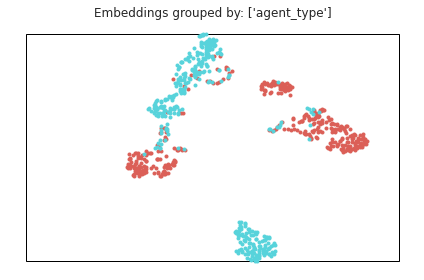

In [16]:
plot_df_embeddings(output_df, 'lstm[64,2]_lstm[64,2]_seed1', 
                   label_by="agent_type", ndims=2, reduce="TSNE")

closest
discount
highest


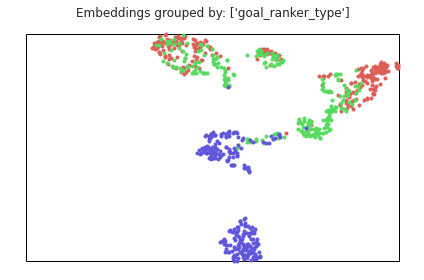

In [23]:
plot_df_embeddings(output_df, 'lstm[64,2]_lstm[64,2]_seed1', 
                   label_by="goal_ranker_type", ndims=2, reduce="TSNE")

0.10.10.10.10.50.50.50.51111
0.10.10.10.111110.50.50.50.5
0.50.50.50.50.10.10.10.11111
0.50.50.50.511110.10.10.10.1
11110.10.10.10.10.50.50.50.5
11110.50.50.50.50.10.10.10.1


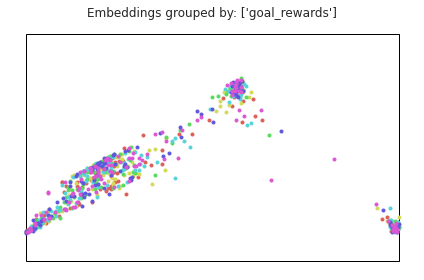

In [20]:
plot_df_embeddings(output_df, 'lstm[64,2]_lstm[64,2]_seed2', 
                   label_by="goal_rewards", ndims=2, reduce="PCA")

In [8]:
agent_specific_df = get_agent_specific_data(model_dict, num_agents_per_cluster=100)

Getting Model Specific Data
	Fetching models output DF


KeyboardInterrupt: 

In [135]:
agent_specific_df.columns

Index(['model_name', 'model_family', 'model_seed', 'lstm_char', 'lstm_mental',
       'char_embedding_size', 'char_n_layer', 'char_n_head',
       'mental_embedding_size', 'mental_n_layer', 'mental_n_head',
       'agent_label', 'agent_type', 'starting_action', 'trigger',
       'action_pattern', 'opponent_idx', 'n_past', 'char_embedding', 'loss',
       'acc', 'starting_action_score', 'starting_action_dim',
       'starting_action_vs_rest_score', 'starting_action_vs_rest_dim',
       'trigger_score', 'trigger_dim', 'trigger_vs_rest_score',
       'trigger_vs_rest_dim', 'action_pattern_score', 'action_pattern_dim',
       'action_pattern_vs_rest_score', 'action_pattern_vs_rest_dim',
       'opponent_idx_score', 'opponent_idx_dim', 'opponent_idx_vs_rest_score',
       'opponent_idx_vs_rest_dim', 'cluster_silhouette_score'],
      dtype='object')

In [145]:
model_specific_df = extract_model_specific_data(agent_specific_df)

Getting Model Specific Data
	Fetching models output DF
	Fetching last layer similarity
	Fetching PCA dims
	Fetching agent param scores


100%|██████████| 16/16 [01:04<00:00,  4.06s/it]
/home/kane0058/Documents/TOMMAS/venv/lib/python3.6/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


	Fetching DCI scores


100%|██████████| 4/4 [00:42<00:00, 10.59s/it]
/home/kane0058/Documents/TOMMAS/venv/lib/python3.6/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [146]:
print(set([i[0] for i in model_specific_df.columns]))

{'wsls_vs_rest_dim', 'final_embedding_distance', 'pca_80%', 'starting_action_vs_rest_dim', 'trigger_vs_rest_dim', 'shared_opponent_idx_score', 'model_name', 'trigger_score', 'starting_action_dim', 'completeness', 'action_pattern_score', 'mental_embedding_size', 'shared_action_pattern_dim', 'pca_90%', 'trigger_dim', 'shared_trigger_score', 'lstm_mental', 'shared_trigger_dim', 'disentanglement', 'mental_n_head', 'opponent_idx_score', 'n_past', 'agent_type_dim', 'shared_starting_action_score', 'shared_action_pattern_score', 'action_pattern_dim', 'starting_action_score', 'grim_trigger_vs_rest_score', 'final_embedding_similarity', 'opponent_idx_dim', 'trigger_vs_rest_score', 'mirror_vs_rest_score', 'loss', 'starting_action_vs_rest_score', 'opponent_idx_vs_rest_score', 'acc', 'action_pattern_vs_rest_score', 'shared_opponent_idx_dim', 'mixed_trigger_pattern_vs_rest_score', 'informativeness', 'agent_type', 'lstm_char', 'char_n_head', 'pca_75%', 'grim_trigger_vs_rest_dim', 'mixed_trigger_patter

In [149]:
model_specific_df

,model_name,model_family,lstm_char,lstm_mental,char_embedding_size,char_n_layer,char_n_head,mental_embedding_size,mental_n_layer,mental_n_head,...,mirror_vs_rest_dim,grim_trigger_vs_rest_score,grim_trigger_vs_rest_dim,wsls_vs_rest_score,wsls_vs_rest_dim,mixed_trigger_pattern_vs_rest_score,mixed_trigger_pattern_vs_rest_dim,disentanglement,completeness,informativeness
,,,,,,,,,,,...,,,,,,,,,,
0,"lstm[128,1]_lstm[48,2]_seed1","lstm[128,1]_lstm[48,2]",True,True,128,1,1,48,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"lstm[128,1]_lstm[48,2]_seed1","lstm[128,1]_lstm[48,2]",True,True,128,1,1,48,2,1,...,8.0,0.821492,2.0,0.376310,13.0,0.246604,4.0,NaN,NaN,NaN
2,"lstm[128,1]_lstm[48,2]_seed1","lstm[128,1]_lstm[48,2]",True,True,128,1,1,48,2,1,...,10.0,0.808070,4.0,0.438751,19.0,0.252684,4.0,NaN,NaN,NaN
3,"lstm[128,1]_lstm[48,2]_seed1","lstm[128,1]_lstm[48,2]",True,True,128,1,1,48,2,1,...,10.0,0.817440,4.0,0.383294,15.0,0.187444,2.0,NaN,NaN,NaN
4,"lstm[128,1]_lstm[48,2]_seed1","lstm[128,1]_lstm[48,2]",True,True,128,1,1,48,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"lstm[128,1]_lstm[48,2]_seed1","lstm[128,1]_lstm[48,2]",True,True,128,1,1,48,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,"lstm[128,1]_lstm[48,2]_seed1","lstm[128,1]_lstm[48,2]",True,True,128,1,1,48,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,"lstm[128,1]_lstm[48,2]_seed1","lstm[128,1]_lstm[48,2]",True,True,128,1,1,48,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,"lstm[128,1]_lstm[48,2]_seed1","lstm[128,1]_lstm[48,2]",True,True,128,1,1,48,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [156]:
model_param_df = aggregate_model_param_data(model_specific_df)

/home/kane0058/Documents/TOMMAS/venv/lib/python3.6/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [161]:
append_representation_similarity_over_diff_init(agent_specific_df, model_param_df)

/home/kane0058/Documents/TOMMAS/venv/lib/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


model_family lstm_char lstm_mental char_embedding_size  \
                                                                        
0    lstm[128,1]_lstm[48,2]      True        True                 128   
1    lstm[128,1]_lstm[48,2]      True        True                 128   
2    lstm[128,1]_lstm[48,2]      True        True                 128   
3    lstm[128,1]_lstm[48,2]      True        True                 128   
4    lstm[128,1]_lstm[48,2]      True        True                 128   
5    lstm[128,1]_lstm[48,2]      True        True                 128   
6    lstm[128,1]_lstm[48,2]      True        True                 128   
7    lstm[128,1]_lstm[48,2]      True        True                 128   
8    lstm[128,1]_lstm[48,2]      True        True                 128   
9    lstm[128,1]_lstm[48,2]      True        True                 128   
10  ttx[80,4,4]_ttx[64,4,4]     False       False                  80   
11  ttx[80,4,4]_ttx[64,4,4]     False       False                  80   
12  ttx[80,4,4]_ttx[64,4,4]     False       False                  80   
13  ttx[80,4,4]_ttx[64,4,4]     False       False                  80   
14  ttx[80,4,4]_ttx[64,4,4]     False       False                  80   
15  ttx[80,4,4]_ttx[64,4,4]     False       False                  80   
16  ttx[80,4,4]_ttx[64,4,4]     False       False                  80   
17  ttx[80,4,4]_ttx[64,4,4]     False       False                  80   
18  ttx[80,4,4]_ttx[64,4,4]     False       False                  80   
19  ttx[80,4,4]_ttx[64,4,4]     False       False                  80   

   char_n_layer char_n_head mental_embedding_size mental_n_layer  \
                                                                   
0             1           1                    48              2   
1             1           1                    48              2   
2             1           1                    48              2   
3             1           1                    48              2   
4             1           1                    48              2   
5             1           1                    48              2   
6             1           1                    48              2   
7             1           1                    48              2   
8             1           1                    48              2   
9             1           1                    48              2   
10            4           4                    64              4   
11            4           4                    64              4   
12            4           4                    64              4   
13            4           4                    64              4   
14            4           4                    64              4   
15            4           4                    64              4   
16            4           4                    64              4   
17            4           4                    64              4   
18            4           4                    64              4   
19            4           4                    64              4   

   mental_n_head n_past  ... completeness informativeness  \
                         ...                                
0              1      0  ...          NaN             NaN   
1              1      1  ...          NaN             NaN   
2              1      2  ...          NaN             NaN   
3              1      3  ...          NaN             NaN   
4              1      4  ...          NaN             NaN   
5              1      5  ...          NaN             NaN   
6              1      6  ...          NaN             NaN   
7              1      7  ...          NaN             NaN   
8              1      8  ...          NaN             NaN   
9              1      9  ...     0.509948        0.799520   
10             4      0  ...          NaN             NaN   
11             4      1  ...          NaN             NaN   
12             4      2  ...          NaN             NaN

In [183]:
extract_architecture_data(agent_specific_df, model_specific_df)

Getting Architecture Data
	Aggregating architecture data


/home/kane0058/Documents/TOMMAS/venv/lib/python3.6/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


	Fetching representation similarity over architecture


/home/kane0058/Documents/TOMMAS/venv/lib/python3.6/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/kane0058/Documents/TOMMAS/venv/lib/python3.6/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/kane0058/Documents/TOMMAS/venv/lib/python3.6/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/kane0058/Documents/TOMMAS/venv/lib/python3.6/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/kane0058/Documents/TOMMAS/venv/lib/python3.6/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/kane0058/Documents/TOMMAS/venv/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


ValueError: zero-size array to reduction operation minimum which has no identity

In [167]:
step = 10
for i, j in enumerate(x[::10]):
    x[i*step:(i+1)*step] = j

In [172]:
avg_x = []
for arr in np.split(x, 10):
    avg_x.append(np.average(arr, axis=0))
avg_x = np.array(avg_x)

In [174]:
x

array([[0.36398339, 0.04631171],
       [0.36398339, 0.04631171],
       [0.36398339, 0.04631171],
       [0.36398339, 0.04631171],
       [0.36398339, 0.04631171],
       [0.36398339, 0.04631171],
       [0.36398339, 0.04631171],
       [0.36398339, 0.04631171],
       [0.36398339, 0.04631171],
       [0.36398339, 0.04631171],
       [0.46258945, 0.19419354],
       [0.46258945, 0.19419354],
       [0.46258945, 0.19419354],
       [0.46258945, 0.19419354],
       [0.46258945, 0.19419354],
       [0.46258945, 0.19419354],
       [0.46258945, 0.19419354],
       [0.46258945, 0.19419354],
       [0.46258945, 0.19419354],
       [0.46258945, 0.19419354],
       [0.45722789, 0.67060874],
       [0.45722789, 0.67060874],
       [0.45722789, 0.67060874],
       [0.45722789, 0.67060874],
       [0.45722789, 0.67060874],
       [0.45722789, 0.67060874],
       [0.45722789, 0.67060874],
       [0.45722789, 0.67060874],
       [0.45722789, 0.67060874],
       [0.45722789, 0.67060874],
       [0.

In [175]:
from scipy.stats.stats import pearsonr

In [179]:
pearsonr(x[:, 0], x[:, 1])

(0.572018836642164, 5.076055940613479e-10)

In [180]:
pearsonr(avg_x[:, 0], avg_x[:, 1])

(0.5720188366421641, 0.08401980661085136)

In [122]:
a = pd.DataFrame([[0, 1, 2], [3, 4, 5], [6, 7, 8]], columns=['a', 'b', 'c'])

In [129]:
a

,a,b,c
0,0,1,2
1,3,4,5
2,6,7,8


In [130]:
a.columns = pd.MultiIndex.from_tuples([(col, "") for col in a.columns], names=[None, None])


In [131]:
a

,a,b,c
,,,
0,0,1,2
1,3,4,5
2,6,7,8


In [72]:
agent_specific_df.columns

Index(['model_name', 'model_family', 'model_seed', 'lstm_char', 'lstm_mental',
       'char_embedding_size', 'char_n_layer', 'char_n_head',
       'mental_embedding_size', 'mental_n_layer', 'mental_n_head',
       'agent_label', 'agent_type', 'starting_action', 'trigger',
       'action_pattern', 'opponent_idx', 'n_past', 'char_embedding', 'loss',
       'acc', 'starting_action_score', 'starting_action_dim',
       'starting_action_vs_rest_score', 'starting_action_vs_rest_dim',
       'trigger_score', 'trigger_dim', 'trigger_vs_rest_score',
       'trigger_vs_rest_dim', 'action_pattern_score', 'action_pattern_dim',
       'action_pattern_vs_rest_score', 'action_pattern_vs_rest_dim',
       'opponent_idx_score', 'opponent_idx_dim', 'opponent_idx_vs_rest_score',
       'opponent_idx_vs_rest_dim', 'cluster_silhouette_score'],
      dtype='object')

In [73]:
agent_specific_df.columns

Index(['model_name', 'model_family', 'model_seed', 'lstm_char', 'lstm_mental',
       'char_embedding_size', 'char_n_layer', 'char_n_head',
       'mental_embedding_size', 'mental_n_layer', 'mental_n_head',
       'agent_label', 'agent_type', 'starting_action', 'trigger',
       'action_pattern', 'opponent_idx', 'n_past', 'char_embedding', 'loss',
       'acc', 'starting_action_score', 'starting_action_dim',
       'starting_action_vs_rest_score', 'starting_action_vs_rest_dim',
       'trigger_score', 'trigger_dim', 'trigger_vs_rest_score',
       'trigger_vs_rest_dim', 'action_pattern_score', 'action_pattern_dim',
       'action_pattern_vs_rest_score', 'action_pattern_vs_rest_dim',
       'opponent_idx_score', 'opponent_idx_dim', 'opponent_idx_vs_rest_score',
       'opponent_idx_vs_rest_dim', 'cluster_silhouette_score'],
      dtype='object')

In [75]:
model_specific_df = extract_model_specific_data(agent_specific_df)

Getting Model Specific Data
	Fetching models output DF
	Fetching last layer similarity
	Fetching PCA dims


/home/kane0058/Documents/TOMMAS/venv/lib/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


	Fetching agent param scores


100%|██████████| 16/16 [01:04<00:00,  4.06s/it]


	Fetching DCI scores


  0%|          | 0/4 [00:00<?, ?it/s]


KeyError: "['agent_type_x'] not in index"

In [ ]:
model_specific_df.columns

In [ ]:
extract_model_param_data(model_specific_df)

In [ ]:
extract_architecture_data(model_specific_df)

## look at data

### Correlation

In [49]:
calculate_and_combine_model_corr(model_specific_df, calculate_model_specific_corr, n_past=5)

,,char_embedding_size_lstm,char_embedding_size_ttx
char_embedding_size,,1.0***,1.0***
pca_75%,,0.85***,-0.33
pca_50%,,0.73***,-0.29
pca_80%,,0.88***,-0.47*
pca_90%,,0.93***,-0.25
action_loss,mean,0.62**,0.97***
action_acc,mean,-0.47*,-0.96***
goal_loss,mean,0.58**,0.91***
goal_acc,mean,-0.58**,0.36
cluster_silhouette_score,mean,0.18,-0.75***


In [50]:
calculate_and_combine_model_corr(model_param_df, calculate_model_param_corr, agg_metric="mean", n_past=5)

,,char_embedding_size_lstm,char_embedding_size_ttx
char_embedding_size,,1.0***,1.0***
diff_init_similarity_score,mean,0.98,-0.99*


In [51]:
for i in calculate_and_combine_model_corr(model_specific_df, calculate_model_specific_corr).iterrows():
    label = ' '.join(i[0][0].split('_'))
    print(label, '&', i[1]["char_embedding_size_lstm"], '&', i[1]["char_embedding_size_ttx"], "\\\\")

char embedding size & 1.0*** & 1.0*** \\
pca 75% & 0.85*** & -0.33 \\
pca 50% & 0.73*** & -0.29 \\
pca 80% & 0.88*** & -0.47* \\
pca 90% & 0.93*** & -0.25 \\
action loss & 0.62** & 0.97*** \\
action acc & -0.47* & -0.96*** \\
goal loss & 0.58** & 0.91*** \\
goal acc & -0.58** & 0.36 \\
cluster silhouette score & 0.18 & -0.75*** \\
shared goal ranker type score & 0.06 & -0.97*** \\
shared goal rewards score & 0.15 & -0.83*** \\
shared goal ranker type dim & -0.23 & 0.07 \\
shared goal rewards dim & 0.02 & -0.48* \\
agent type score & -0.61** & -0.95*** \\
agent type dim & 0.49* & 0.24 \\
disentanglement & 0.35 & -0.76*** \\
completeness & 0.74*** & -0.57** \\
informativeness & -0.66*** & -0.99*** \\


### Performance Metrics

In [16]:
def overall_performance_boxplot(df, metric, n_past=5, x="char_embedding_size", agg_metric="mean", ax=None):
    past_df = df.copy()
    past_df['Architecture'] = np.where(past_df['lstm_char'] == True, "lstm", "transformer")
    if isinstance(n_past, int):
        n_past = [n_past]
    past_df = past_df[(past_df["n_past"].isin(n_past))]

    y = past_df[("goal_" + metric, agg_metric)] + past_df[("action_" + metric, agg_metric)]
    if metric == "acc":
        y = y/2

    sns.boxplot(x=past_df[x],
                y=y,
                hue=past_df["Architecture"],
                ax=ax)

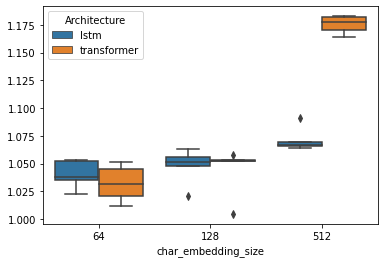

In [17]:
overall_performance_boxplot(model_specific_df, "loss")

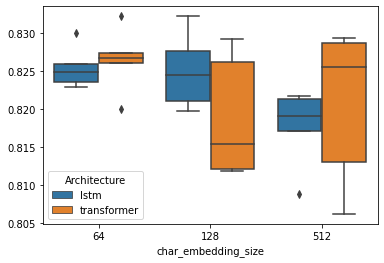

In [18]:
overall_performance_boxplot(model_specific_df, "acc")

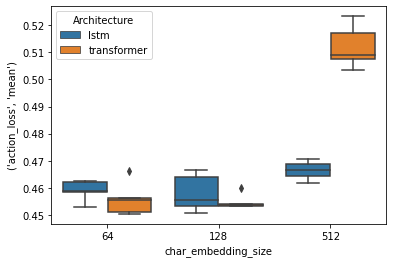

In [19]:
lstm_ttx_boxplot_comparison(model_specific_df, ("action_loss", "mean"))

Med (LSTM, TTX): (0.582, 0.576), (0.598, 0.599), (0.600, 0.660)
Avg (LSTM, TTX): (0.581, 0.576), (0.590, 0.589), (0.605, 0.663)


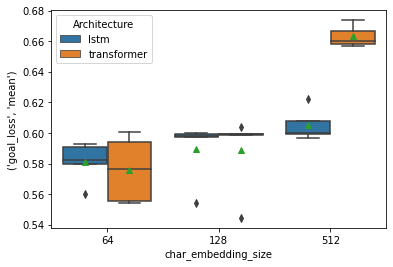

In [43]:
lstm_ttx_boxplot_comparison(model_specific_df, ("goal_loss", "mean"), verbose=True, showmeans=True)

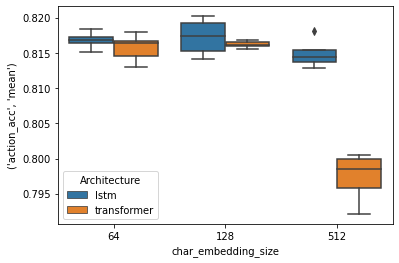

In [21]:
lstm_ttx_boxplot_comparison(model_specific_df, ("action_acc", "mean"))

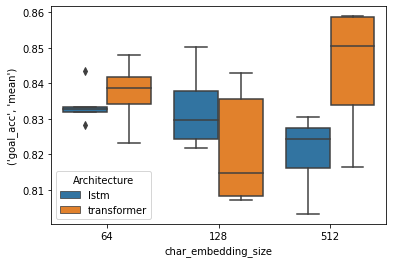

In [22]:
lstm_ttx_boxplot_comparison(model_specific_df, ("goal_acc", "mean"))

### DCI

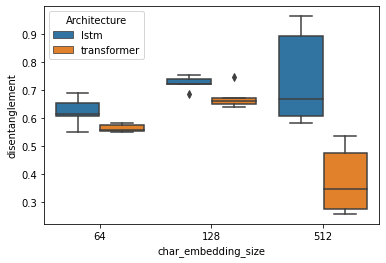

In [24]:
lstm_ttx_boxplot_comparison(model_specific_df, "disentanglement")

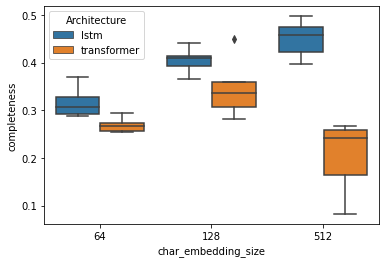

In [25]:
lstm_ttx_boxplot_comparison(model_specific_df, "completeness")

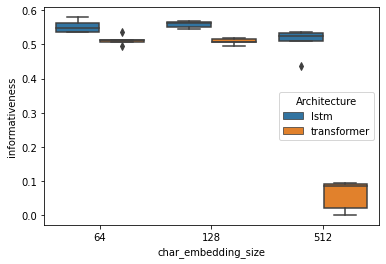

In [26]:
lstm_ttx_boxplot_comparison(model_specific_df, "informativeness")

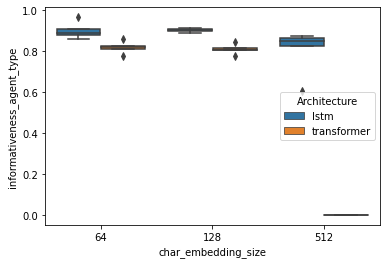

In [57]:
lstm_ttx_boxplot_comparison(model_specific_df, "informativeness_agent_type")

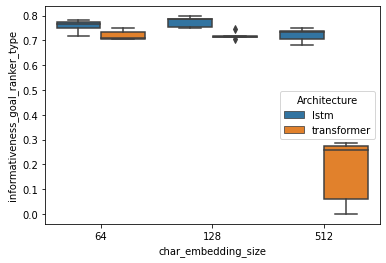

In [58]:
lstm_ttx_boxplot_comparison(model_specific_df, "informativeness_goal_ranker_type")

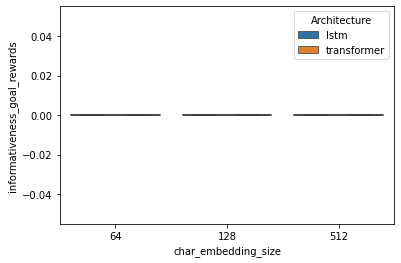

In [59]:
lstm_ttx_boxplot_comparison(model_specific_df, "informativeness_goal_rewards")

### Cluster

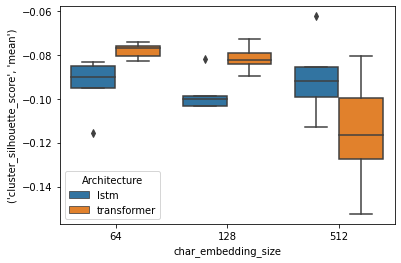

In [52]:
lstm_ttx_boxplot_comparison(model_specific_df, "cluster_silhouette_score")

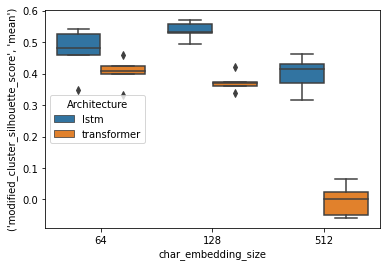

In [53]:
lstm_ttx_boxplot_comparison(model_specific_df, "modified_cluster_silhouette_score")

### PCA

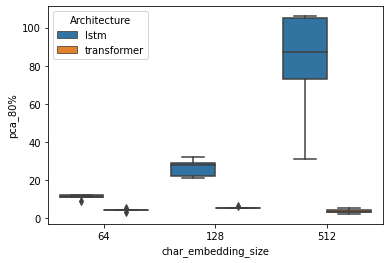

In [29]:
lstm_ttx_boxplot_comparison(model_specific_df, "pca_80%")

### Convergence

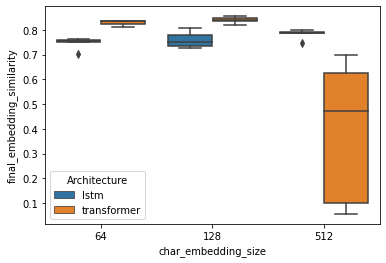

In [30]:
lstm_ttx_boxplot_comparison(model_specific_df, "final_embedding_similarity", n_past=1)

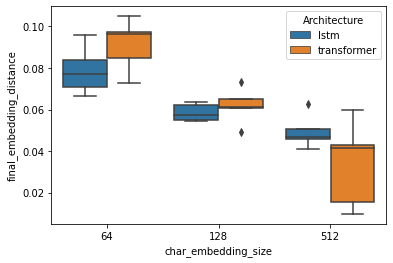

In [31]:
lstm_ttx_boxplot_comparison(model_specific_df, "final_embedding_distance", n_past=1)

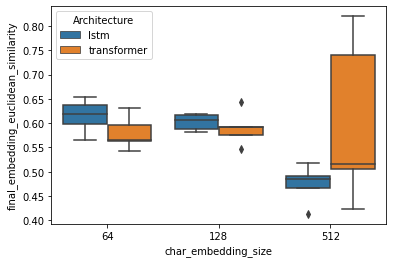

In [32]:
lstm_ttx_boxplot_comparison(model_specific_df, "final_embedding_euclidean_similarity", n_past=1)

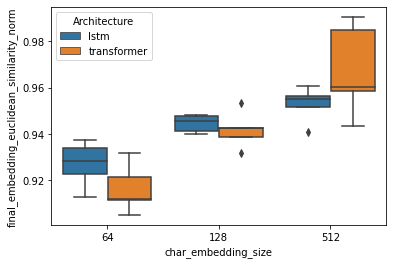

In [33]:
lstm_ttx_boxplot_comparison(model_specific_df, "final_embedding_euclidean_similarity_norm", n_past=1)

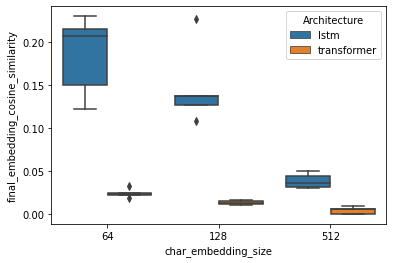

In [34]:
lstm_ttx_boxplot_comparison(model_specific_df, "final_embedding_cosine_similarity", n_past=1)

In [35]:
def calculate_final_embedding_convergence(df):
    def riemann_sum(n_past_values):
        dx = 1
        midpoints = (n_past_values[:-1] + n_past_values[1:]) / 2
        return np.sum(midpoints*dx) / len(n_past_values)
    
    sim_convg = []
    dist_convg = []
    data = []
    for (model_name, model_df) in df[["model_name", "char_embedding_size", "lstm_char", "n_past", "final_embedding_similarity", "final_embedding_distance"]].groupby(["model_name"]):
        char_embedding_size = model_df.char_embedding_size.iloc[0]
        lstm_char = model_df.lstm_char.iloc[0]
        similarities = np.array(model_df["final_embedding_similarity"].tolist())
        distances = np.array(model_df["final_embedding_distance"].tolist())
        data.append({"char_embedding_size": char_embedding_size, 
                     "Architecture": ("lstm" if lstm_char else "transformer"), 
                     "npast_1_sim": similarities[1],
                     "npast_1_dist": distances[1],
                     "similarity_convergence": riemann_sum(similarities), 
                     "distance_convergence": riemann_sum(distances) / max(distances),})
        
    convg_df = pd.DataFrame(data)
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    sns.boxplot(x=convg_df["char_embedding_size"],
                y=convg_df["similarity_convergence"],
                hue=convg_df["Architecture"],
                ax=axes[0])
    sns.boxplot(x=convg_df["char_embedding_size"],
                y=convg_df["distance_convergence"],
                hue=convg_df["Architecture"],
                ax=axes[1])
    plt.show()
#     print("lstm")
#     print(calculate_df_corr(convg_df[convg_df["Architecture"] == "lstm"]))
#     print("ttx")
#     print(calculate_df_corr(convg_df[convg_df["Architecture"] == "transformer"]))


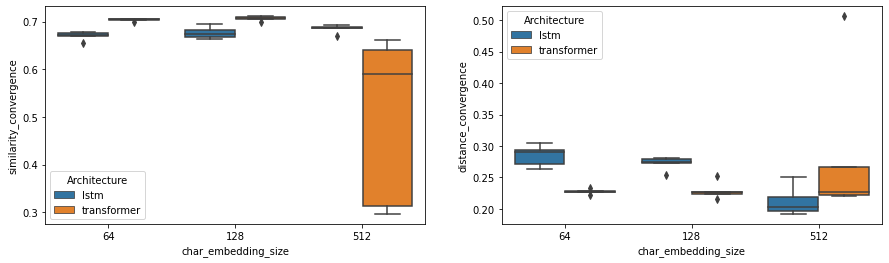

In [36]:
calculate_final_embedding_convergence(model_specific_df)

### Stability

#### Different Initialization

<AxesSubplot:xlabel='char_embedding_size', ylabel="('diff_init_similarity_score', 'mean')">

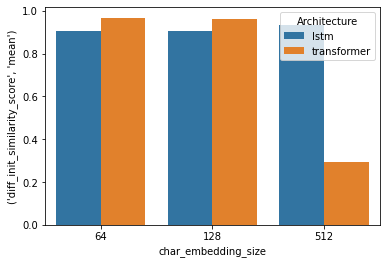

In [60]:
diff_init = model_param_df.copy()
diff_init['Architecture'] = np.where(diff_init['lstm_char'] == True, "lstm", "transformer")
sns.barplot(x="char_embedding_size", y=("diff_init_similarity_score", "mean"), data=diff_init[diff_init["n_past"] == 5], hue="Architecture")

#### Different Parameterization

<AxesSubplot:xlabel='Architecture', ylabel="('architecture_similarity_score', 'mean')">

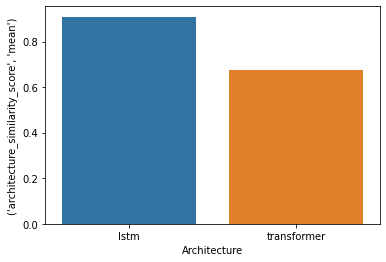

In [61]:
diff_param = architecture_df.copy()
diff_param['Architecture'] = np.where(diff_param['lstm_char'] == True, "lstm", "transformer")
sns.barplot(x="Architecture", y=("architecture_similarity_score", "mean"), data=diff_param[diff_param["n_past"] == 5], order=["lstm", "transformer"])
# sns.barplot(x=, y=("architecture_similarity_score", "mean"), data=diff_param)


In [62]:
architecture_df[architecture_df["n_past"] == 5]

lstm_char lstm_mental n_past action_loss                               \
                                      count     mean       std       min   
5      False       False      5        36.0  0.47426  0.115687  0.322884   
11      True        True      5        36.0  0.46124  0.116319  0.307877   

                                  ... completeness informativeness  \
         25%       50%       75%  ...                                
5   0.377836  0.450337  0.591519  ...     0.272885        0.360561   
11  0.361318  0.437344  0.576763  ...     0.390239        0.540174   

   architecture_similarity_score                                          \
                           count      mean       std       min       25%   
5                           1050  0.674973  0.374131  0.009420  0.009420   
11                          1050  0.908836  0.031687  0.792467  0.792467   

                                  
         50%       75%       max  
5   0.009420  0.009420  0.977248  
11  0.792467  0.792467  0.961803  

[2 rows x 103 columns]

In [34]:
def get_cross_embedding_representation_similarity(df, cross_type="architecture"):
    import re

    def atoi(text):
        return int(text) if text.isdigit() else text

    def natural_keys(text):
        '''
        alist.sort(key=natural_keys) sorts in human order
        http://nedbatchelder.com/blog/200712/human_sorting.html
        (See Toothy's implementation in the comments)
        '''
        return [ atoi(c) for c in re.split(r'(\d+)', text) ]
    
    def get_avg_sim_scores(embeddings_a, embeddings_b):
        sim_scores = []
        for embeddings in itertools.product(embeddings_a, embeddings_b):
            _, indiv_sim_scores = get_representation_similarity_score(embeddings, similarity="cka")
            sim_scores.append(indiv_sim_scores)
        return np.average(sim_scores)
    
    def get_cross_embedding_sim_matrix(df_a, df_b, families_a, families_b):
        sim_matrix = np.zeros((len(families_a), len(families_b)))
        for i, family_a in enumerate(families_a):
            for j, family_b in enumerate(families_b):
                embeddings_a = df_a[family_a].groupby(["model_seed"])["char_embedding"].apply(
                    lambda a: np.vstack(a)).tolist()
                embeddings_b = df_b[family_b].groupby(["model_seed"])["char_embedding"].apply(
                    lambda a: np.vstack(a)).tolist()
                sim_matrix[i, j] = get_avg_sim_scores(embeddings_a, embeddings_b)
        return sim_matrix
    
    def plot_sim_matrix(sim_matrix, ax, row_families, col_families):
        ax.imshow(sim_matrix, cmap="hot", interpolation="nearest", vmin=0., vmax=1.0)
#         for i in range(len(strategy_order)):
#             for j in range(len(strategy_order)):
#                 text = plt.text(j, i, "{:.2f}".format(sim_matrix[i, j]), ha="center", va="center", color="b")
#         ax.set_xticks(len(col_families))
        ax.set_xticks(range(len(col_families)))
        ax.set_xticklabels(col_families, rotation=90)
        ax.set_yticks(range(len(row_families)))
        ax.set_yticklabels(row_families)

    lstm_embedding_df = df[(df["lstm_char"] == True)][["model_family", "model_seed", "n_past", "char_embedding"]]
    ttx_embedding_df = df[(df["lstm_char"] == False)][["model_family", "model_seed", "n_past", "char_embedding"]]
    lstm_families = lstm_embedding_df["model_family"].unique().tolist()
    lstm_families.sort(key=natural_keys)
    ttx_families = ttx_embedding_df["model_family"].unique().tolist()
    ttx_families.sort(key=natural_keys)
    for n_p in [5]:
        lstm_past_df = lstm_embedding_df[lstm_embedding_df["n_past"] == n_p]
        ttx_past_df = ttx_embedding_df[ttx_embedding_df["n_past"] == n_p]
        lstm_dfs = dict(tuple(lstm_past_df.groupby(["model_family"])))
        ttx_dfs = dict(tuple(ttx_past_df.groupby(["model_family"])))

        print("Arch")
        fig, ax = plt.subplots()
        sim_matrix = get_cross_embedding_sim_matrix(lstm_dfs, ttx_dfs, lstm_families, ttx_families)
        plot_sim_matrix(sim_matrix, ax, lstm_families, ttx_families)
        plt.show()
        print(f"min: {np.min(sim_matrix)}, max: {np.max(sim_matrix)}, avg: {np.mean(sim_matrix)}")
            
        print("LSTM")
        fig, ax = plt.subplots()
        sim_matrix = get_cross_embedding_sim_matrix(lstm_dfs, lstm_dfs, lstm_families, lstm_families)
        plot_sim_matrix(sim_matrix, ax, lstm_families, lstm_families)
        plt.show()
        print(f"min: {np.min(sim_matrix)}, max: {np.max(sim_matrix)}, avg: {np.mean(sim_matrix)}")
        
        print("TTX")
        fig, ax = plt.subplots()
        sim_matrix = get_cross_embedding_sim_matrix(ttx_dfs, ttx_dfs, ttx_families, ttx_families)
        plot_sim_matrix(sim_matrix, ax, ttx_families, ttx_families)
        plt.show()
        print(f"min: {np.min(sim_matrix)}, max: {np.max(sim_matrix)}, avg: {np.mean(sim_matrix)}")


Arch


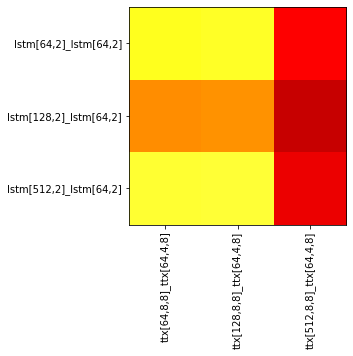

min: 0.28245524546964734, max: 0.7997021108527673, avg: 0.589288409894476
LSTM


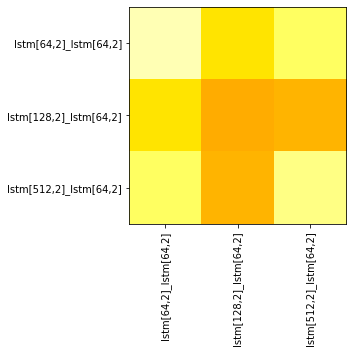

min: 0.6230502873437747, max: 0.924165773534884, avg: 0.7545594995073361
TTX


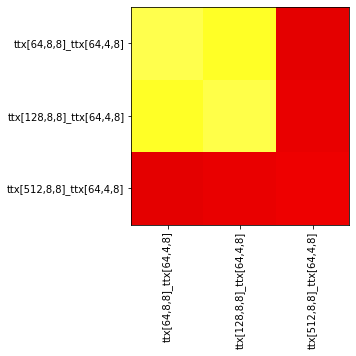

min: 0.3254194854687973, max: 0.8221571110425284, avg: 0.5407665910247833


In [35]:
get_cross_embedding_representation_similarity(agent_specific_df)

### Agent Params

#### Shared

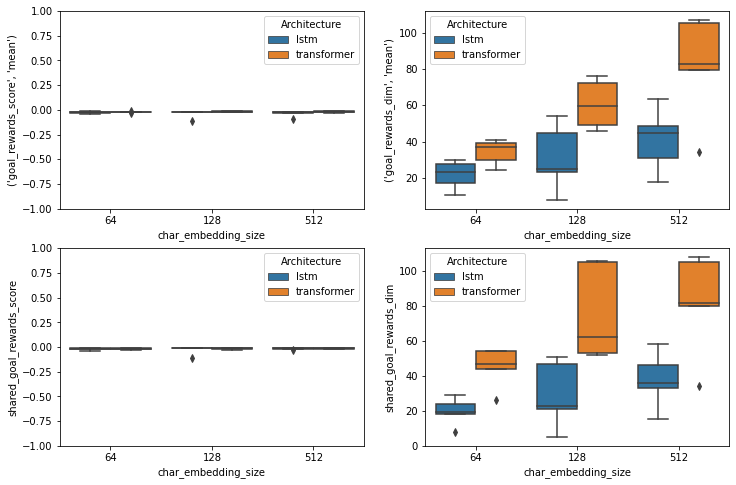

In [19]:
lstm_ttx_agent_param_boxplot_comparison(model_specific_df, "goal_rewards", compare="shared")

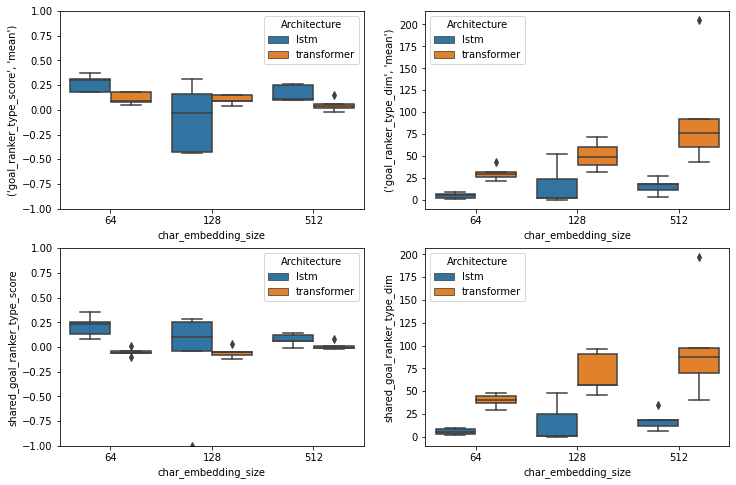

In [20]:
lstm_ttx_agent_param_boxplot_comparison(model_specific_df, "goal_ranker_type", compare="shared")

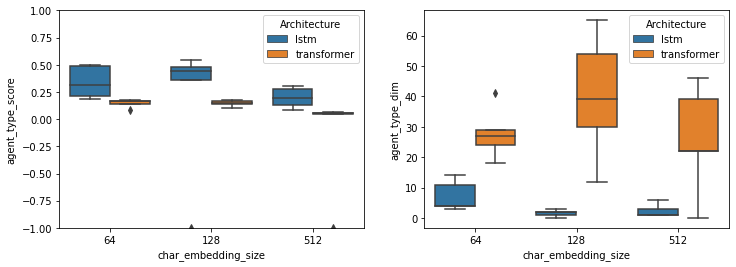

In [21]:
lstm_ttx_agent_param_boxplot_comparison(model_specific_df, "agent_type")

# looking at embedding distribution

In [36]:
def plot_embedding_space_as_boxplot(df, model_name="lstm[64,1]_lstm[64,2]_seed1", percentile_order=-1):
    embeddings = np.vstack(df[(df["model_name"]==model_name) & (df["n_past"] == 5)].char_embedding.tolist())
    if percentile_order == -1:
        if "ttx" in model_name:
            percentile_order = 2
        else: 
            percentile_order = 0
    percentiles = np.percentile(embeddings, [0, 25, 50, 75, 100], axis=0)
    embeddings = embeddings[:, np.argsort(percentiles[percentile_order, :])]
    fig, ax = plt.subplots(figsize=(18, 6))
    g1 = sns.boxplot(data=embeddings, ax=ax)
    g1.set(xticks=[], ylim=(-1.5, 1.5))

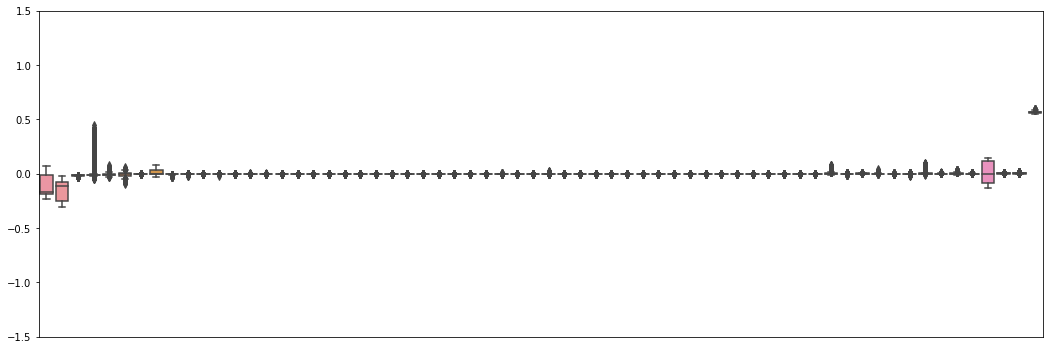

In [37]:
plot_embedding_space_as_boxplot(agent_specific_df, 'lstm[64,2]_lstm[64,2]_seed1', percentile_order=2)

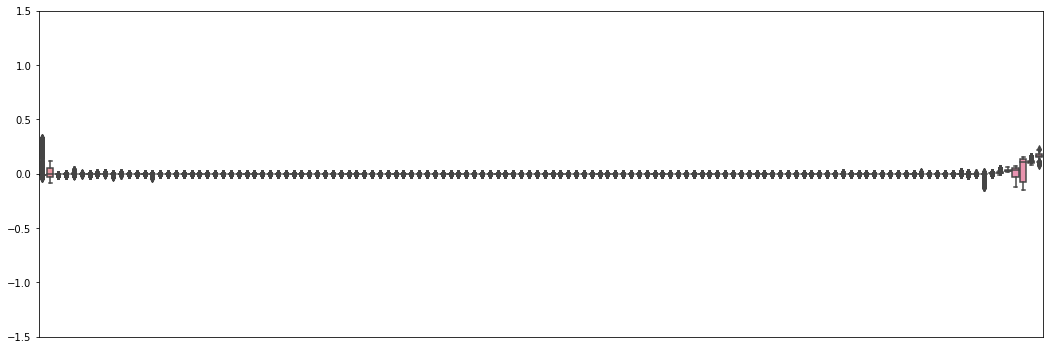

In [38]:
plot_embedding_space_as_boxplot(agent_specific_df, 'lstm[128,2]_lstm[64,2]_seed1', percentile_order=2)

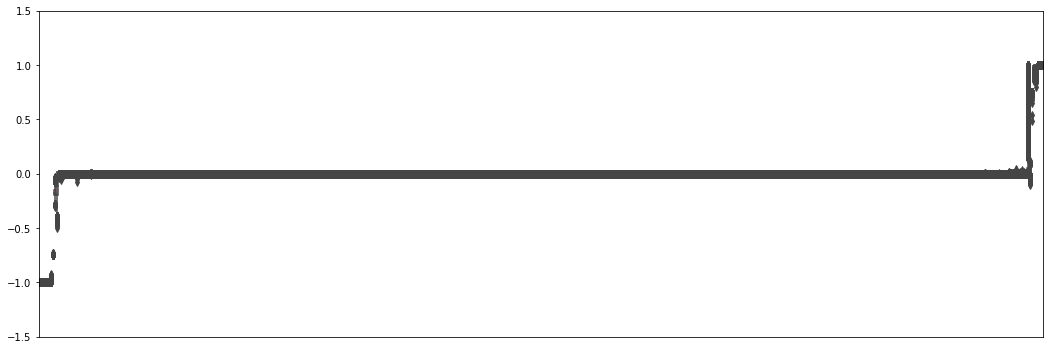

In [39]:
plot_embedding_space_as_boxplot(agent_specific_df, 'lstm[512,2]_lstm[64,2]_seed1', percentile_order=2)

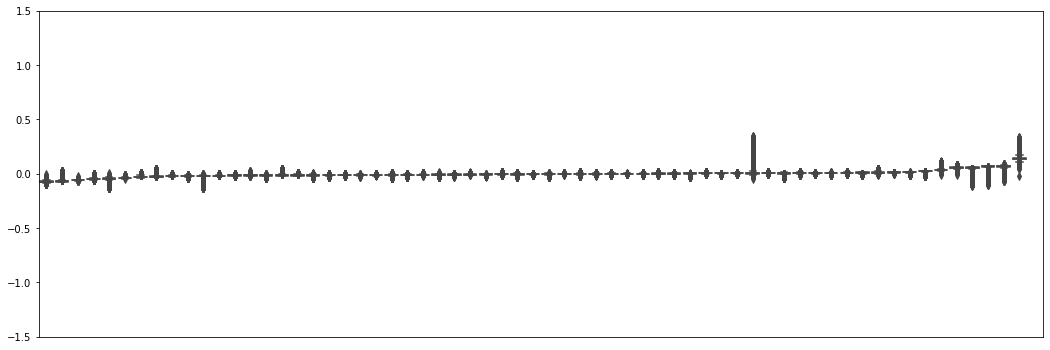

In [40]:
plot_embedding_space_as_boxplot(agent_specific_df, 'ttx[64,8,8]_ttx[64,4,8]_seed5', percentile_order=2)

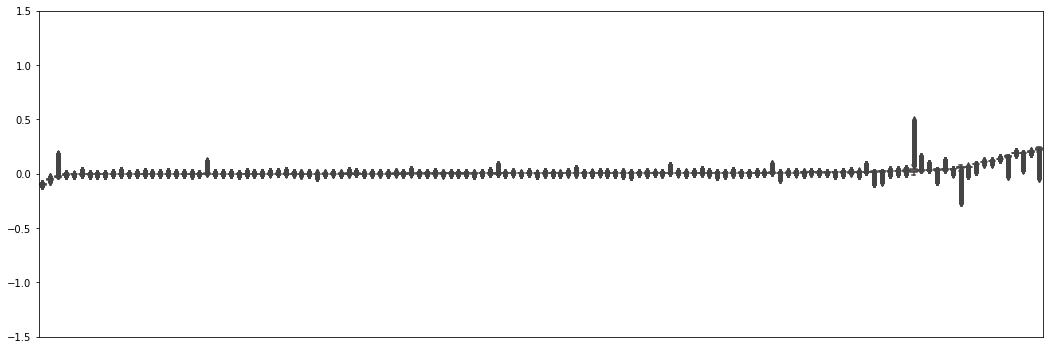

In [41]:
plot_embedding_space_as_boxplot(agent_specific_df, 'ttx[128,8,8]_ttx[64,4,8]_seed5', percentile_order=2)

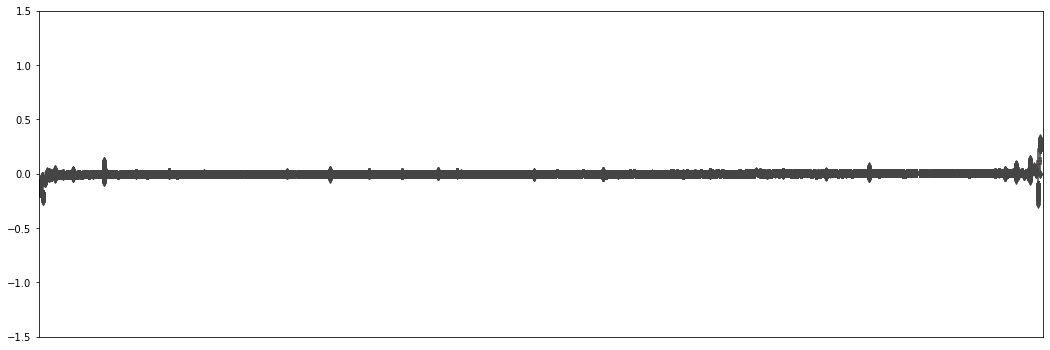

In [42]:
plot_embedding_space_as_boxplot(agent_specific_df, 'ttx[512,8,8]_ttx[64,4,8]_seed1', percentile_order=2)

In [44]:
def append_distributional_variance(agent_specific_df, model_specific_df):
    data = []
    models_names = agent_specific_df["model_name"].unique()
    for model_name in models_names:
        embedding_df = agent_specific_df[agent_specific_df["model_name"] == model_name][["n_past", "char_embedding"]]
        x = embedding_df.groupby(["n_past"])["char_embedding"].apply(lambda a: np.vstack(a))
        n_past = len(x)
        for n_p in range(n_past):
            embeddings = x[n_p]
            overall_var = np.mean(np.var(embeddings, axis=0))
            cov_mean = np.mean(np.cov(embeddings.T))
            
            data.append({"model_name": model_name, "n_past": n_p, "overall_var": overall_var,
                         "cov_mean": cov_mean})
    df = pd.DataFrame(data)
    df.columns = pd.MultiIndex.from_tuples([(col, "") for col in df.columns], names=[None, None])
    return model_specific_df.merge(df, how="left", on=["model_name", "n_past"])


In [45]:
model_specific_df = append_distributional_variance(agent_specific_df, model_specific_df)

/home/kane0058/Documents/TOMMAS/venv/lib/python3.6/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [46]:
var_corr_comp = ["cluster_silhouette_score", "char_embedding_size", "shared_goal_rewards_score", "shared_goal_ranker_type_score", "agent_type_score", "final_embedding_similarity", "completeness", "disentanglement", "informativeness", "overall_var", "cov_mean"]
model_specific_df[(model_specific_df["n_past"] == 5) & (model_specific_df["lstm_char"] == True)].corr()[["overall_var", "cov_mean"]].loc[var_corr_comp]

# var_corr_comp = ["cluster_silhouette_score", "char_embedding_size", "shared_goal_rewards_score", "shared_goal_ranker_type_score", "agent_type_score", "final_embedding_similarity", "completeness", "disentanglement", "informativeness", "overall_var_x", "cov_mean_x"]
# model_specific_df[(model_specific_df["n_past"] == 5) & (model_specific_df["lstm_char"] == True)].corr()[["overall_var_x", "cov_mean_x"]].loc[var_corr_comp]


overall_var  cov_mean
                                                         
cluster_silhouette_score      count         NaN       NaN
                              mean    -0.268963 -0.194188
                              std      0.458367  0.177276
                              min     -0.606960 -0.158118
                              25%     -0.183538 -0.137496
                              50%     -0.447830 -0.322974
                              75%      0.022356 -0.057069
                              max      0.538562  0.182236
char_embedding_size                   -0.780335 -0.735320
shared_goal_rewards_score             -0.613059 -0.259071
shared_goal_ranker_type_score         -0.114700  0.028999
agent_type_score                       0.562574  0.678175
final_embedding_similarity            -0.101973 -0.147935
completeness                          -0.789144 -0.828532
disentanglement                       -0.430984 -0.463048
informativeness                        0.419072  0.472713
overall_var                            1.000000  0.720030
cov_mean                               0.720030  1.000000

In [47]:
model_specific_df[(model_specific_df["n_past"] == 5) & (model_specific_df["lstm_char"] == False)].corr()[["overall_var", "cov_mean"]].loc[var_corr_comp]


overall_var  cov_mean
                                                         
cluster_silhouette_score      count         NaN       NaN
                              mean     0.491612  0.376839
                              std      0.009593 -0.036662
                              min      0.190666  0.185352
                              25%      0.300311  0.234417
                              50%      0.580910  0.436298
                              75%      0.604006  0.466652
                              max      0.774559  0.370719
char_embedding_size                   -0.799959 -0.517179
shared_goal_rewards_score              0.690654  0.634394
shared_goal_ranker_type_score          0.818432  0.525387
agent_type_score                       0.821858  0.585065
final_embedding_similarity            -0.204906 -0.352432
completeness                           0.295314  0.260100
disentanglement                        0.499019  0.382621
informativeness                        0.767699  0.504082
overall_var                            1.000000  0.611735
cov_mean                               0.611735  1.000000

In [48]:
model_specific_df[(model_specific_df["n_past"] == 5)].corr()[["overall_var", "cov_mean"]].loc[var_corr_comp]


overall_var  cov_mean
                                                         
cluster_silhouette_score      count         NaN       NaN
                              mean     0.328165 -0.025373
                              std      0.016030  0.294250
                              min      0.015825 -0.197795
                              25%      0.176597 -0.117056
                              50%      0.278763 -0.162043
                              75%      0.376030  0.208227
                              max      0.332334  0.446173
char_embedding_size                   -0.722605 -0.516254
shared_goal_rewards_score              0.143436  0.275912
shared_goal_ranker_type_score          0.279318  0.463577
agent_type_score                       0.620926  0.446945
final_embedding_similarity            -0.148537 -0.162533
completeness                          -0.169466  0.052696
disentanglement                        0.055120  0.155477
informativeness                        0.460426  0.427886
overall_var                            1.000000  0.244621
cov_mean                               0.244621  1.000000

In [83]:
def hist_all_embeddings(df, model_name, norm_x=False):
    binrange=(-1.5, 1.5)
    char_embed_size = df[(df["model_name"]==model_name)].char_embedding_size.unique()[0]
    cols = 8
    rows = char_embed_size // cols
    embeddings = np.vstack(df[(df["model_name"]==model_name) & (df["n_past"]==5)].char_embedding.tolist())
    embeddings = embeddings[:, np.argsort(np.var(embeddings, axis=0))]
    col_size = 15
    row_size = int(col_size * (rows / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(col_size, row_size))
    for i in range(rows):
        for j in range(cols):
#             g = sns.kdeplot(embeddings[:, 8*i+j], ax=axes[i,j])
#             bincount, bins = np.histogram(embeddings[:, (cols*i)+j], bins=100, range=(-1.5, 1.5))
#             print(np.sort(bincount)[-4:])
            embedding1d = embeddings[:, (cols*i)+j]
            g = sns.histplot(embeddings[:, (cols*i)+j], ax=axes[i,j], bins=100, stat="percent", binrange=binrange)
            if norm_x:
                g.set(xlim=(np.min(embedding1d), np.max(embedding1d)), ylim=(0, 20), ylabel='')
            else:
                g.set(xlim=binrange, ylim=(0, 20), ylabel='')
    plt.plot()

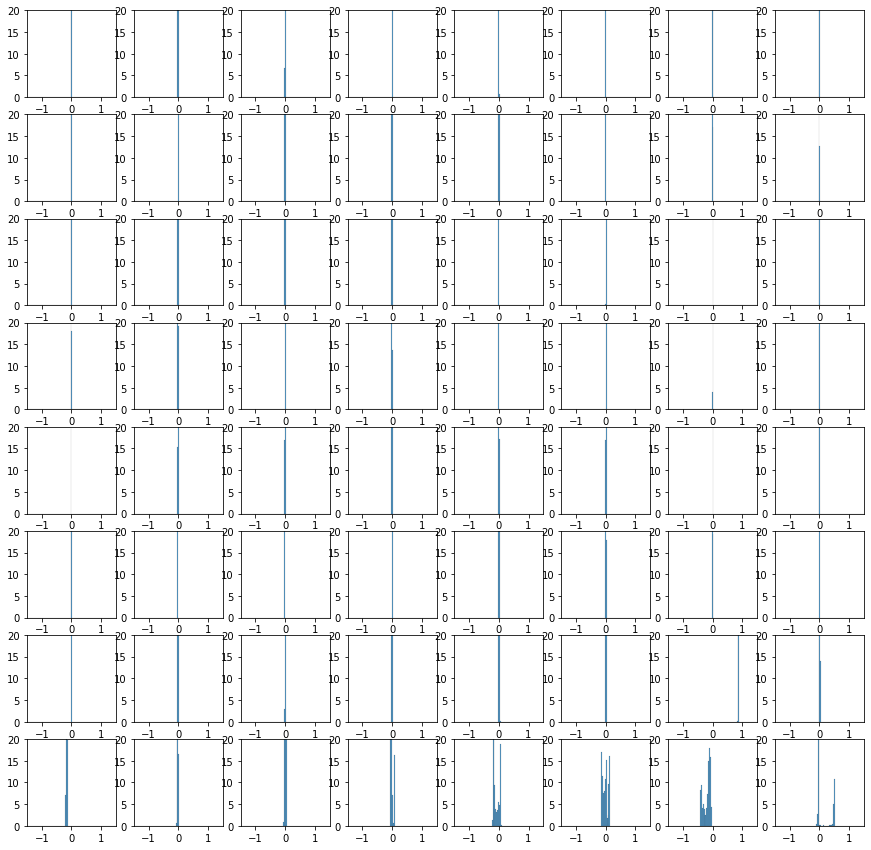

In [84]:
hist_all_embeddings(agent_specific_df, "lstm[64,2]_lstm[64,2]_seed1", norm_x=False)

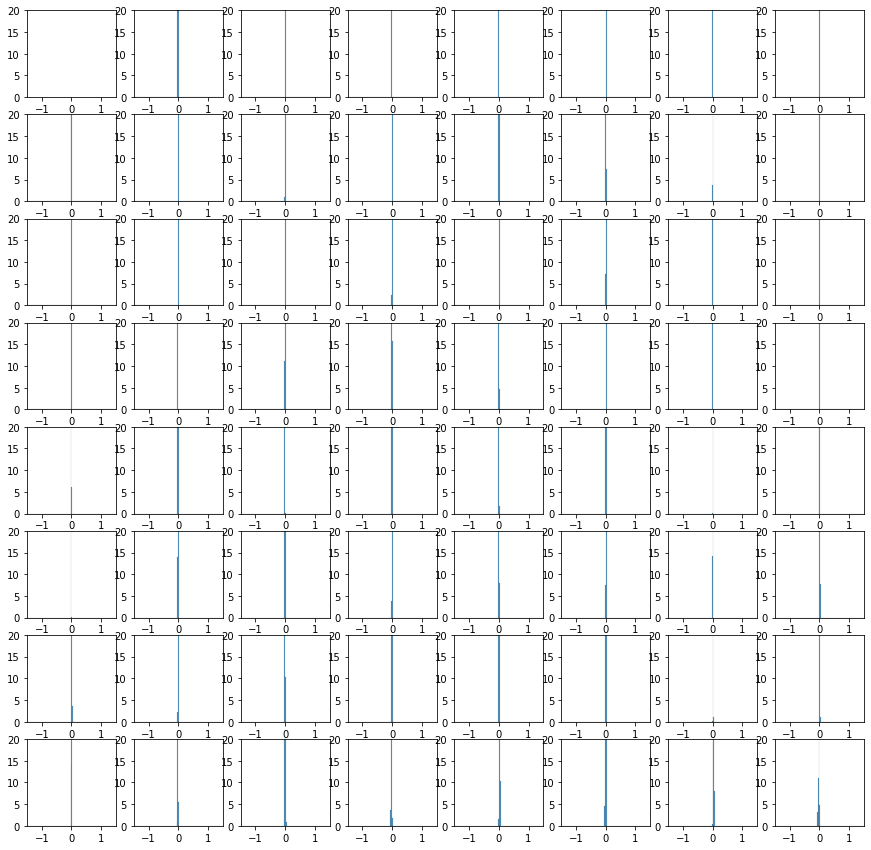

In [85]:
hist_all_embeddings(agent_specific_df, "ttx[64,8,8]_ttx[64,4,8]_seed1", norm_x=False)